##IMPORTING ALL THE REQUIRED LIBRARIES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
import shutil
import re,string
import copy
!pip install pdfminer.six
from pdfminer.high_level import extract_text # to extract text from pdf by blocks
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.7 MB/s eta 0:00:00


##Extracting the abstract part from research papers

In [3]:
abstracts = [] #contains all abstracts
for files in os.listdir('/content/drive/MyDrive/karan'):
  text = extract_text('/content/drive/MyDrive/karan/'+ files) # for extracting text from pdf #string
  text_by_lines =  text.split('\n') # contains text by lines #list

  # to extract abstract
  # if the text that was extracted contains the heading abstract then this code will extract the abstract paragraph from the whole paper
  if ('abstract' in text.lower()) or ('a b s t r a c t' in text.lower()):
    start = 0
    end = 1
    for i, line in enumerate(text_by_lines):
      if ('a b s t r a c t' in line.lower()) or ('abstract' in line.lower()):
        start = i
        break
    for i, line in enumerate(text_by_lines[start:]):
      if ('introduction' in line.lower()) or ('content' in line.lower()) or ('c o n t e n t' in line.lower()) or ('i n t r o d u c t i o n' in line.lower()):
        end = start + i
        break
    if len((" ".join(text_by_lines[start:end])).split())> 50:
      abstracts.append(" ".join(text_by_lines[start:end]))
    else:
      counter = 0
      abstract = []
      for i in text_by_lines: # iterating through each line
        if i != '':
          counter +=1
          abstract.append(i)
        if i == '':
          if counter <8:
            abstract.clear()
            counter = 0
          elif counter >= 8:
            if len((' '.join(abstract)).split())>50:
              break
            else:
              abstract.clear()
              counter = 0
      abstracts.append(' '.join(abstract))


  else: # i.e, if abstract heading is not available in the research paper then it takes the first paragraph as abstract
    counter = 0
    abstract = []
    for i in text_by_lines: # iterating through each line
      if i != '':
        counter +=1
        abstract.append(i)
      if i == '':
        if counter <8:
          abstract.clear()
          counter = 0
        elif counter >= 8:
          if len((' '.join(abstract)).split())>50:
            break
          else:
            abstract.clear()
            counter = 0
    abstracts.append(' '.join(abstract))


In [4]:
all_abstracts = copy.deepcopy(abstracts)

In [5]:
#These are stop_words in common taken from intenet.
stop_word=["a","about","above","after","again","against","all","am","an","and","any","are","as","at","be","because","been","before","being","below","between","both","but",
"by",'can',"could","did","do","does","doing","down","during","each","few","for","from","further","had","has","have","having","he","he'd","he'll","he's","her",
"here","here's","hers","herself","him","himself","his","how","how's","i","i'd","i'll","i'm","i've","if","in","into","is","it","it's","its","itself","let's","me",
"more","most","my","myself","nor","of","on","once","only","or","other","ought","our","ours","ourselves","out","over","own","same","she",
"she'd","she'll","she's","should","so","some","such","than","that","that's","the","their","theirs","them","themselves","then","there","there's",
"these","they","they'd","they'll","they're","they've","this","those","through","to","too","under","until","up","very","was","we","we'd",
"we'll","we're","we've","were","what","what's","when","when's","where","where's","which","while","who","who's","whom","why","why's","with",
"would","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves",'abstract','introduction','a b s t r a c t','i n t r o d u c t i o n']

##Word Embedding

In [6]:
#Making Dictionary of words with their corresponding frequency (Hashmapping)
dic={}
for each_abstract in abstracts:
  words = each_abstract.split()
  for word in words:
    word = word.lower()
    if not(word.isalpha()) or word in stop_word or len(word)<=2:
      continue
    if word in dic:
      dic[word]+=1
    else:
      dic[word]=1

In [7]:
#Sorting the dictionary on basis of frequency of words in descending order
sorted_dic = sorted(dic.items(), key=lambda item : item[1] ,reverse=True)
print(len(sorted_dic))
sorted_dic[:5]

2193


[('energy', 216),
 ('hydrogen', 122),
 ('green', 76),
 ('renewable', 66),
 ('solar', 62)]

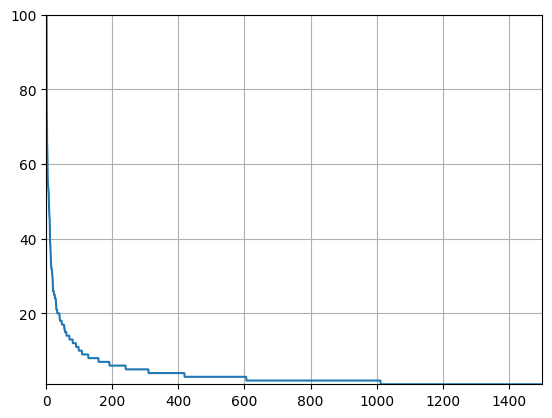

In [8]:
# ploting the frequency graph
features=sorted_dic
x_values=[]
y_values=[]
for i in range(len(features)):
    x_values.append(i)
    y_values.append(features[i][1])
plt.plot(x_values,y_values)
plt.axis([0,1500,1,100])
plt.grid()
plt.show()

In [9]:
# taking first 400 as features for a simple model: (features are nothing but words itself)

model_features=[features[i][0] for i in range(400)]

In [11]:
#No. of rows is equivalent to no. of files, and column is equal to length of feature list taken i.e, 20
embedded_dataset=np.zeros([len(abstracts),len(model_features)],int)
for i in range(len(abstracts)):
    words=abstracts[i].lower()
    word=re.split(r'\W+',words)
    #Iterating over each word
    for j in word:
        #We will add the frequency corresponding to that word only which is in our x(feature list)
        if j in model_features:
            embedded_dataset[i][model_features.index(j)]+=1

In [12]:
print(len(embedded_dataset),len(embedded_dataset[0]))
embedded_dataset

50 400


array([[ 2,  0,  1, ...,  0,  0,  0],
       [12,  0,  1, ...,  0,  0,  0],
       [ 6,  7,  4, ...,  0,  0,  0],
       ...,
       [ 4,  0,  0, ...,  0,  0,  0],
       [ 2,  0,  0, ...,  0,  0,  0],
       [ 5,  0,  0, ...,  0,  0,  0]])

In this dataset, each row represents an abstract and each column represents the words. Therefore, each cell represents the frequency of the word that is appearing in the particular abstract.

##Creating Dataset using TF-IDF vectorizer

In [14]:
tfidf = TfidfVectorizer(stop_words= stop_word) # removing stop words
tf_idf_dataset = tfidf.fit_transform(abstracts) # parsing through abstracts
feature_names =  tfidf.get_feature_names_out()

Using Elbow Method to know the optimal no. of clusters.

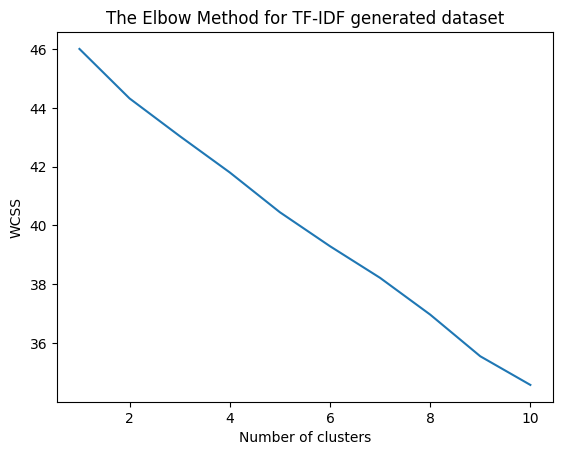

In [15]:
# for TF-IDF generated Dataset
wcss = []

# Running K-means for K values from 1 to 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(tf_idf_dataset)
    wcss.append(kmeans.inertia_)

# Ploting the WCSS values against the number of clusters
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method for TF-IDF generated dataset')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

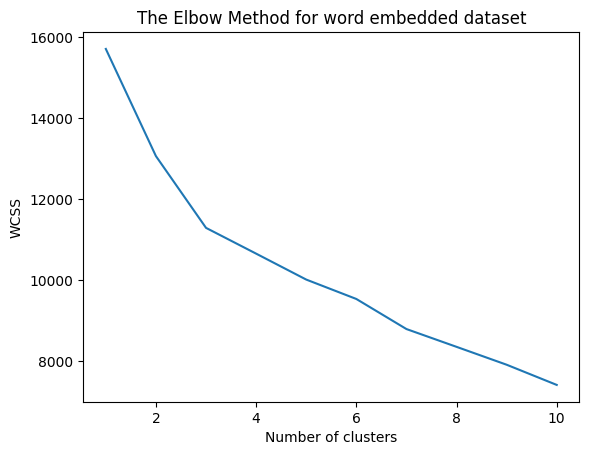

In [16]:
# for Dataset that was created without using any python libraries
wcss = []

# Running K-means for K values from 1 to 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(embedded_dataset)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values against the number of clusters
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method for word embedded dataset')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

couldn't find the optimal no. of clusters by this method so going for Sihouette Analysis.

##Sihouette Analysis

For n_clusters = 2, the average silhouette score is: 0.014856265365199723
For n_clusters = 3, the average silhouette score is: 0.015966193490367847
For n_clusters = 4, the average silhouette score is: 0.015209251224874536
For n_clusters = 5, the average silhouette score is: 0.01875634815126527
For n_clusters = 6, the average silhouette score is: 0.022267475575411456
For n_clusters = 7, the average silhouette score is: 0.023501512570448656
For n_clusters = 8, the average silhouette score is: 0.020806021857574478


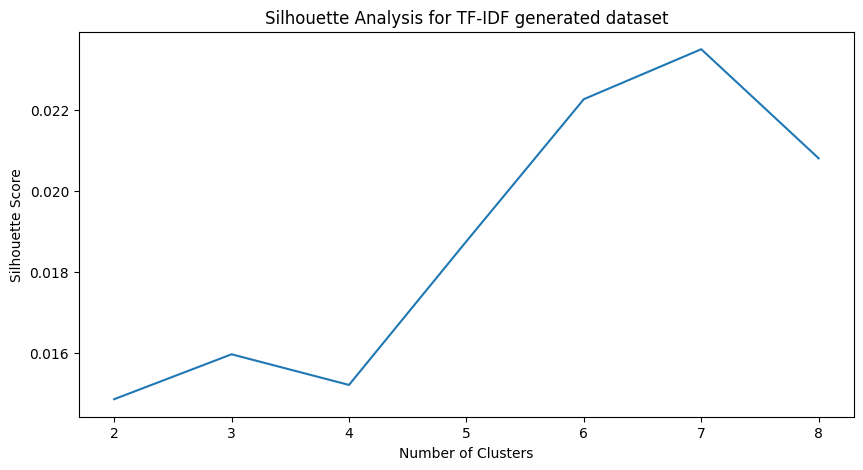

In [17]:
# for TF-IDF generated Dataset
# Load your data into X
X = tf_idf_dataset

# Run K-Means for different number of clusters
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg}")

# Plot the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for TF-IDF generated dataset")
plt.show()

For n_clusters = 2, the average silhouette score is: 0.5742041037336618
For n_clusters = 3, the average silhouette score is: 0.22779038307902968
For n_clusters = 4, the average silhouette score is: 0.16350548938755025
For n_clusters = 5, the average silhouette score is: 0.09861308434244799
For n_clusters = 6, the average silhouette score is: 0.08420004786545007
For n_clusters = 7, the average silhouette score is: 0.13874964803761505
For n_clusters = 8, the average silhouette score is: 0.029105568144733734


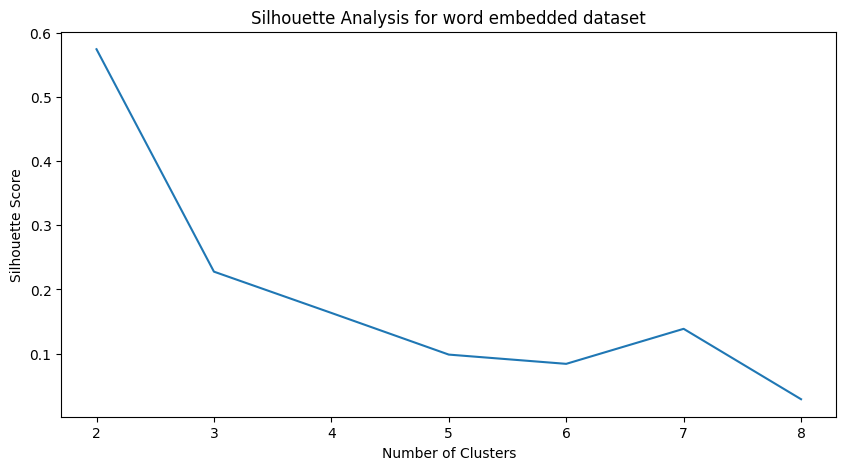

In [18]:
# for Dataset that was created without using any python libraries
# Load your data into X
X = embedded_dataset

# Run K-Means for different number of clusters
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg}")

# Plot the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for word embedded dataset")
plt.show()

##DBscan

In [19]:
X = tf_idf_dataset

# Apply DBSCAN clustering
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


Estimated number of clusters: 0
Estimated number of noise points: 50


DBScan took everything into Noise Points, So it doesnt fit for our case.

##Taking optimal no. of clusters as 7 and proceeding with KMeans Classifier

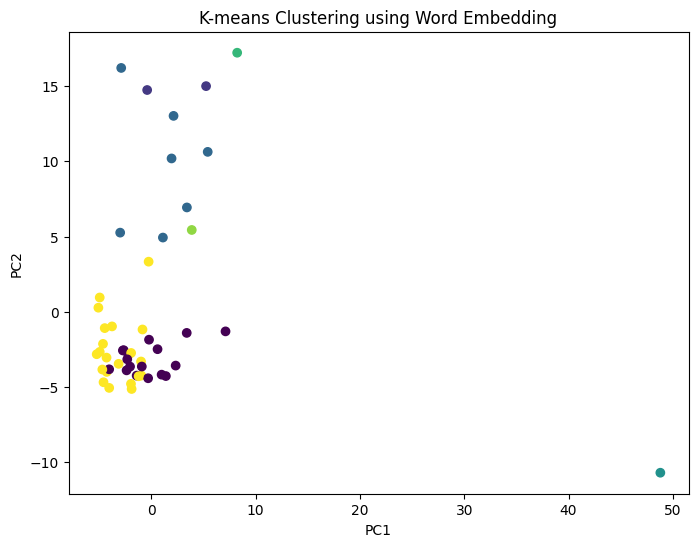

In [21]:
# taking optimal no. of clusters as 7 from both silhouette analysis and Elbow method for Dataset that was created without using any python libraries.
kmeans = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(embedded_dataset)
labels = kmeans.fit_predict(embedded_dataset)

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(embedded_dataset)

# Plot the clustering results
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering using Word Embedding')
plt.show()

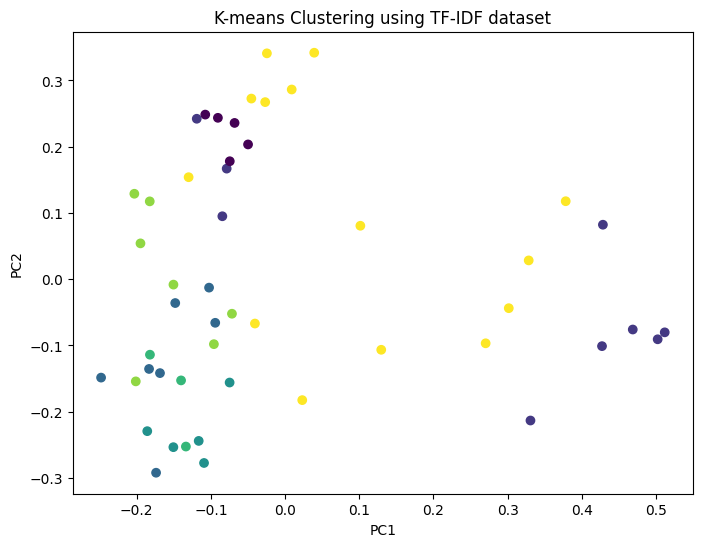

In [22]:
# taking optimal no. of clusters as 7 from both silhouette analysis and Elbow method for TF-IDF genereated dataset.
kmeans = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(tf_idf_dataset)
labels = kmeans.fit_predict(tf_idf_dataset)

# Reduce dimensionality using PCA

pca = PCA(n_components=2)
X_dense = tf_idf_dataset.toarray()
X_reduced = pca.fit_transform(X_dense)

# Plot the clustering results
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering using TF-IDF dataset')
plt.show()

##Based on The Graphs that are produced, the best one would be TF-IDF generated dataset and Through K Means clustering the optimal no. of clusters will be 7.

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(tf_idf_dataset)
labels = kmeans.fit_predict(tf_idf_dataset)

In [24]:
# There are 7 clusters so creating 7 different folders
num_folders = 7

for folder_num in range(0, num_folders):
    folder_path = f"Folder{folder_num}"
    os.makedirs(folder_path, exist_ok=True)

# assigning each file to their respecttive folders
for i, file_name in enumerate(os.listdir('/content/drive/MyDrive/karan')):
    cluster_num = labels[i]
    folder_path = f"Folder{cluster_num}"
    src_file = '/content/drive/MyDrive/karan/'+ file_name
    dst_file = os.path.join(folder_path, file_name)
    shutil.copy(src_file, dst_file)

In [26]:
from collections import Counter

no_of_files_in_each_folder = dict(Counter(labels))

print(no_of_files_in_each_folder)

{2: 7, 0: 5, 1: 9, 5: 7, 6: 14, 3: 5, 4: 3}


##Explaination Part:
This Code extracts the Abstract part from the research papers.

TF-IDF vectorization method was used to vectorize the Text from each abstract.

Clustering Methods like Kmeans and DBScan were used to make clusters and using Elbow method and silhouette analysis, it was determined that the optimal no. of clusters would be 7 and the model used in creating these clusters was KMeans classifier.

Then all the given research papers were classified based on the clustering labels and were distributed to seperate folders.

It has been verified manually that the classification technique used is correct and the research papers are classified properly.

In [ ]:
from nbconvert.exporters import HTMLExporter
import nbformat

# Load the IPython Notebook file
with open('/content/karan.ipynb', 'r') as f:
    notebook = nbformat.read(f, as_version=4)

# Create an instance of the HTMLExporter
exporter = HTMLExporter()

# Export the notebook to HTML
(body, resources) = exporter.from_notebook_node(notebook)

# Save the HTML output to a file
with open('output_notebook.html', 'w', encoding='utf-8') as f:
    f.write(body)
